The goal here is to find parameters for the `QuasiKarnoppDamper` friction model using the baseline devices + `nevergrad` to see if the constants can be applied over to the optimal device.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Let's define our model that we need to simulate
from scipy.signal import savgol_filter
import numpy as np

from unified_model import unified
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel


In [3]:
from local_config import ABC_CONFIG

/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/electrical_components/flux/model.py:55: UserWarning: n_z and n_w are set, but are not required if no `curve_model` is specified.
  warnings.warn('n_z and n_w are set, but are not required if no `curve_model` is specified.')  # noqa


In [66]:
# Top collision
which_device = 'A'

# Magnet Assembly
magnet_assembly_optim = mechanical_components.MagnetAssembly(
    m=2,
    l_m_mm=10,
    l_mcd_mm=24,
    dia_magnet_mm=10,
    dia_spacer_mm=10
)
magnet_assembly = ABC_CONFIG.magnet_assembly

mech_spring = mechanical_components.MechanicalSpring(
    magnet_assembly=magnet_assembly,
    position=150/1000,  # position of the microgenerator "top" (in metres)
    damping_coefficient=10  # Controls how "lossy" the impact is.
) 

mech_spring

MechanicalSpring(position=0.15, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=10)

In [67]:
# Magnetic spring
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_length=10 / 1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)

In [68]:
# Electrical components
# Load
load = electrical_components.SimpleLoad(R=30)

# Rectifier loss
v_rect_drop = 0.1


In [69]:
# Params
c = 1
n_z = 88
n_w = 20

# Coupling model
coupling = CouplingModel().set_coupling_constant(5.0)

# Coil
coil_config = ABC_CONFIG.coil_configs[which_device]

In [8]:
flux_model = ABC_CONFIG.flux_models[which_device]
dflux_model = ABC_CONFIG.dflux_models[which_device]

In [9]:
# Get our input excitation and groundtruth data
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any

@dataclass
class MechanicalGroundtruth:
    y_diff: Any
    time: Any

@dataclass
class ElectricalGroundtruth:
    emf: Any
    time: Any

@dataclass
class Groundtruth:
    mech: MechanicalGroundtruth
    elec: ElectricalGroundtruth

samples_list = collect_samples(base_path='../data/2019-05-23_D/',
                               acc_pattern=f'{which_device}/*acc*.csv',
                               adc_pattern=f'{which_device}/*adc*.csv',
                               video_label_pattern=f'{which_device}/*labels*.csv')
        
class GroundTruthFactory:
    def __init__(self,
                 samples_list,
                 lvp_kwargs,
                 adc_kwargs):
        """Helper Factory to get groundtruth data in a batch."""
        
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return MechanicalGroundtruth(y_target,
                                     y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return ElectricalGroundtruth(emf_target,
                                     emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            try:
                mech_groundtruth = self._make_mechanical_groundtruth(sample)
                elec_groundtruth = self._make_electrical_groundtruth(sample)

                groundtruths.append(
                    Groundtruth(mech_groundtruth, elec_groundtruth)
                )
            except AttributeError:
                pass

        return groundtruths


class AccelerometerInputsFactory:
    def __init__(self, sample_list, acc_input_kwargs=None):
        self.sample_list = sample_list
        self.acc_input_kwargs = {} if acc_input_kwargs is None else acc_input_kwargs  # noqa
        self._set_defaults()

    def _set_defaults(self):
        self.acc_input_kwargs.setdefault('accel_column', 'z_G'),
        self.acc_input_kwargs.setdefault('time_column', 'time(ms)'),
        self.acc_input_kwargs.setdefault('accel_unit', 'g'),
        self.acc_input_kwargs.setdefault('time_unit', 'ms'),
        self.acc_input_kwargs.setdefault('smooth', True),
        self.acc_input_kwargs.setdefault('interpolate', True)

    def make(self) -> np.ndarray:
        accelerometer_inputs = []
        for sample in self.sample_list:
            acc_input = mechanical_components.AccelerometerInput(
                raw_accelerometer_input=sample.acc_df,
                accel_column=self.acc_input_kwargs.setdefault('accel_column', 'z_G'),  # noqa
                time_column=self.acc_input_kwargs.setdefault('time_column', 'time(ms)'),  # noqa
                accel_unit=self.acc_input_kwargs.setdefault('accel_unit', 'g'),
                time_unit=self.acc_input_kwargs.setdefault('time_unit', 'ms'),
                smooth=self.acc_input_kwargs.setdefault('smooth', True),
                interpolate=self.acc_input_kwargs.setdefault('interpolate', True)  # noqa
            )
            accelerometer_inputs.append(acc_input)
        return np.array(accelerometer_inputs)
 
    
# Prepare data
groundtruth_factory = GroundTruthFactory(samples_list,
                                        lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                        seconds_per_frame=1/60,
                                                        pixel_scale=0.154508),
                                        adc_kwargs=dict(voltage_division_ratio=1 / 0.342))
accelerometer_factory = AccelerometerInputsFactory(samples_list)
groundtruth = groundtruth_factory.make()
input_excitations = accelerometer_factory.make()

In [10]:
# Build the unified model
from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import UnifiedModel
from unified_model import pipeline
from unified_model import governing_equations

mechanical_model = MechanicalModel() \
    .set_damper(None) \
    .set_magnet_assembly(magnet_assembly) \
    .set_magnetic_spring(magnetic_spring) \
    .set_mechanical_spring(mech_spring) \

electrical_model = ElectricalModel() \
    .set_rectification_drop(v_rect_drop) \
    .set_load_model(load) \
    .set_flux_model(flux_model, dflux_model) \
    .set_coil_configuration(coil_config)

unified_model = UnifiedModel() \
    .set_mechanical_model(mechanical_model) \
    .set_electrical_model(electrical_model) \
    .set_coupling_model(coupling) \
    .set_post_processing_pipeline(pipeline.clip_x2, name='clip tube velocity') \
    .set_governing_equations(governing_equations.unified_ode)  # Here we set our governing equations for my particular microgenerator. We'll go over this a bit later.

In [11]:
damper = mechanical_components.damper.QuasiKarnoppDamper(
    4.7857,
    0.050,
    magnet_assembly,
    5.5 
)

mechanical_components.damper.QuasiKarnoppDamper?

Init signature:
mechanical_components.damper.QuasiKarnoppDamper(
    coulomb_damping_coefficient: float,
    motional_damping_coefficient: float,
    magnet_assembly: unified_model.mechanical_components.magnet_assembly.MagnetAssembly,
    tube_inner_radius_mm: float,
) -> None
Docstring:      A damper that is based on a modified Karnopp friction model.
Init docstring: Constructor
File:           ~/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py
Type:           type
Subclasses:     


Here we use nevergrad to run the simulations and find the best parameters for the damper.

In [54]:
def minimize(b_m1, b_m2):
    unified_model.reset()
    damper = mechanical_components.damper.QuasiKarnoppDamper(
        coulomb_damping_coefficient=b_m1,
        motional_damping_coefficient=b_m2,
        magnet_assembly=unified_model.mechanical_model.magnet_assembly,
        tube_inner_radius_mm=5.5
    )
    
    unified_model.mechanical_model.set_damper(damper)
    mech_result, _, _, _ = run(input_excitations[0], groundtruth[0], unified_model)
    return mech_result['dtw_distance']
    

def run(input_, groundtruth, unified_model):
    unified_model.mechanical_model.set_input(input_)
    y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
    unified_model.solve(t_start=0, t_end=8, y0=y0, t_eval=np.linspace(0, 8, 1000), t_max_step=1e-3)
    mech_result, mech_eval = unified_model.score_mechanical_model(
        y_target=groundtruth.mech.y_diff,
        time_target=groundtruth.mech.time,
        metrics_dict={'dtw_distance': metrics.dtw_euclid_distance},
        prediction_expr='x3-x1',
        return_evaluator=True
    )
    elec_result, elec_eval = unified_model.score_electrical_model(
        emf_target=groundtruth.elec.emf,
        time_target=groundtruth.elec.time,
        metrics_dict={'rms_perc_diff': metrics.root_mean_square_percentage_diff,
                      'rms': metrics.root_mean_square,
                      'dtw_distance': metrics.dtw_euclid_distance},
        prediction_expr='g(t, x5)',
        return_evaluator=True
    )
    return mech_result, mech_eval, elec_result, elec_eval


In [40]:
minimize(8.785, 0.000)

10.869157615824747

In [45]:
# Nevergrad part
import nevergrad as ng

bm1 = ng.p.Scalar(lower=0, upper=7, init=5)
bm2 = ng.p.Scalar(lower=-0.02, upper=0.02, init=0)
instru = ng.p.Instrumentation(bm1, bm2)

def my_callback(optimizer, candidate, value):
    print(candidate.value[0], value)

optimizer = ng.optimizers.NGOpt(parametrization=instru, budget=100)
optimizer.register_callback("tell", my_callback)
recommendation = optimizer.minimize(minimize)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=nan, Thu Mar 11 18:42:49 2021)


/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(5*x - x0)))


(5.360008186927587, -0.010540624639644914) 18.568742044775863
(5.159151843233515, 0.005662705645164663) 13.701610106705012
(5.172870050082894, -0.0011243063327065921) 16.773158346593636
(3.6963524449848837, -0.00392617148403534) 21.08603843003039
(4.943818474119369, -0.002581134691373726) 17.322736618708234
(5.369827800188504, -0.0053421107196996) 17.35760982925555
(4.493061772409577, -0.0010142903004442035) 18.49306353088508
(5.76426879330788, -0.0013028553858947598) 13.479518683525887
(5.326297801308374, 0.006731342816350196) 10.62144984463153
(5.457809533777138, 0.012939557957896714) 11.957544817843461
(5.545933316983777, 0.0008168574731500715) 14.188745588860652
(6.018123470370625, 0.003705818780112485) 10.301233144653857
(6.874767117158926, 0.0028091623678817364) 10.308737512781354


/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(5*x - x0)))


(5.980221868017488, 0.004106713576032362) 10.329124076536425
(4.541848526033602, -0.0003621531961264446) 18.227750303778635
(6.359704228517008, 0.0009734451136168296) 12.729185662171739
(6.5822990238943575, 0.008768417283868497) 10.926391595727676
(6.524072046336008, 0.005133052662083289) 10.416239413793278
(4.327425218651062, 0.0030862338938564974) 17.91766690640463
(6.264998895974781, 0.002811022109212586) 11.854969053350537
(6.51443274543802, 0.007465673757592521) 10.441093557083445
(6.669633953517542, 0.004078831668501609) 10.337683620918103
(5.822474695214153, 0.004618730344747407) 10.35938095297907
(6.982558133835615, 0.004836669013840631) 10.610744881945381
(6.2400895438374, 0.007195186121759561) 10.186848092076673
(6.228788173439588, 0.008822382205015925) 10.672427933535769
(6.959938325633093, 0.0069155261116895074) 10.62160601386325


/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(5*x - x0)))


(5.027986626943638, 0.0018492395007142517) 13.708783978711871
(6.87730465621557, 0.004487758758468078) 10.418030095227266
(5.668057325594156, 0.005927859132302357) 10.473033030575298
(6.133180802373846, 0.008996786602585348) 10.666326444941134
(6.117492653474824, 0.0081249646447838) 10.355482200784067
(5.611660422154942, 0.010490300691382954) 10.894254055050054
(6.042030825970858, 0.012399364314449724) 13.200242456613006
(5.768328573965553, 0.006153042952103427) 10.48704074178665
(6.522801630542199, 0.002945222454073285) 10.338968023300112
(6.213027423596919, 0.0076961520474537045) 10.297827521010856
(6.199418929384635, 0.004570418420811956) 10.31385311221866
(6.190148856345138, 0.0015581439251300523) 12.650797229448528
(6.174967822393911, 0.003798790830430358) 10.330652600437404
(5.623106586952241, 0.00376492666115044) 11.576788123576815
(6.8484477472821235, 0.002829856011818851) 10.316669318886435
(6.3194909798562255, 0.009008628318733006) 10.812968889817009
(6.027332727736097, 0.006

/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(5*x - x0)))


(6.260191445930531, 0.0029008754279916493) 11.795786031815844
(6.124758043992124, 0.007935647090522462) 10.30750429468657
(6.263734862238, 0.006930460357671788) 10.143136149372271
(6.539563399310831, 0.0071032922204283255) 10.361936044445637
(6.1721737770479, 0.006432041262127727) 10.539918712221406
(6.171164665069733, 0.006165899168872054) 10.486818492000909
(6.519598667140798, 0.006504018188479954) 10.212703165115272
(6.024876812552408, 0.006171135810453943) 10.492123461322922
(5.780094139584909, 0.00921458299261909) 10.487438440283933
(6.288100204606531, 0.008179417008582802) 10.494010348411168
(6.642159424400387, 0.0062234353481598415) 10.246074204056466
(6.204590782732426, 0.006006185308659002) 10.476700101075055
(6.277048989768197, 0.00666283068034659) 10.099322046254287
(6.173128404817677, 0.007956269297103327) 10.343172475185444
(6.389728450592888, 0.005860349106625337) 10.49852478739903
(6.310989917980012, 0.007277621038226466) 10.251718409303749
(6.377212563138864, 0.00657783

/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(5*x - x0)))


(6.300390429974723, 0.006191127056131934) 10.529600640959263
(6.346093138670841, 0.007023935175396171) 10.214751377430535
(6.106880790890512, 0.006678067783200915) 10.5956212974809
(5.933318901495946, 0.007429638293193392) 10.06470461003822
(6.039008631764401, 0.007075709025326908) 10.866052504267666
(6.217239968334717, 0.008793027944458635) 10.656143154682754
(6.512284982362495, 0.006628916044047044) 10.23163794237898
(6.471302632889902, 0.008096635101782943) 10.599525945452916
(5.966588540069468, 0.007334697992743148) 10.061586584571126
(6.601970601687909, 0.005896389799475237) 9.933247266699794
(6.4140269017153075, 0.006086792391673248) 10.579615601625797


/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(5*x - x0)))


(5.800340601045297, 0.006806981671858639) 10.588180282589047
(5.897307734421703, 0.007488704174952318) 10.057569457721018
(5.913054925633675, 0.007024238405469287) 10.626125224450146
(6.245611232595541, 0.0061229163659987365) 10.50832211399471
(6.283626810389763, 0.006269910457002708) 10.54545164326121
(6.468062106327206, 0.006731910700175519) 10.227496134651581
(6.558139026229674, 0.006185365760769571) 10.186665415632207
(6.121240917779118, 0.007152674083366663) 10.105665725394356
(6.51528131327319, 0.006188225401742836) 10.162312107160917


/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(5*x - x0)))


(6.480373606388401, 0.005653155978384328) 10.485195331960313
(6.321801787788016, 0.006421377123343777) 10.754967646642264
(5.863582652260533, 0.007379138091565089) 10.805961095389357
(6.310468590796624, 0.00668482723423414) 10.120541053651506
(6.030068553497581, 0.007547550466935358) 10.137543432844284
(5.856691901225183, 0.007203296748573522) 10.655743972866233
(6.035930279064936, 0.007345853345542056) 10.097170186640223
(6.261448807108681, 0.006980224078119259) 10.153647049426093


In [53]:
print(recommendation.value[0])
print(recommendation.loss)

(6.601970601687909, 0.005896389799475237)
9.933247266699794


In [23]:
minimize(8, 0.01)

{'dtw_distance': 14.483971685686917}

In [20]:
len(input_excitations)

7

In [51]:

custom_damper = mechanical_components.damper.QuasiKarnoppDamper(
    coulomb_damping_coefficient=recommendation.value[0][0],
    motional_damping_coefficient=recommendation.value[0][1],
    magnet_assembly=magnet_assembly,
    tube_inner_radius_mm=5.5 
)

print(custom_damper.cdc)
print(custom_damper.mdc)

unified_model.mechanical_model.set_damper(custom_damper)

6.601970601687909
0.005896389799475237


{'dtw_distance': 9.2018461965674}


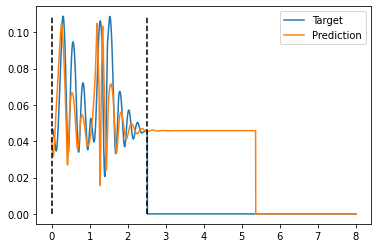

In [65]:
which = 1
mech_result, mech_eval, _, _ = run(input_excitations[which], groundtruth[which], unified_model)
print(mech_result)
mech_eval.poof()

In [13]:
# Run simulation
y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
unified_model.solve(t_start=0, t_end=8, y0=y0, t_eval=np.linspace(0, 8, 1000), t_max_step=1e-3)

In [14]:
results = unified_model.get_quick_results()
results.head()

,time,rel_pos_mag,rel_pos_vel,v_load
0,0.000000,0.032500,0.000000,0.0
1,0.008008,0.032486,-0.003359,0.0
2,0.016016,0.032447,-0.006288,0.0
3,0.024024,0.032387,-0.008640,0.0
4,0.032032,0.032311,-0.010312,0.0


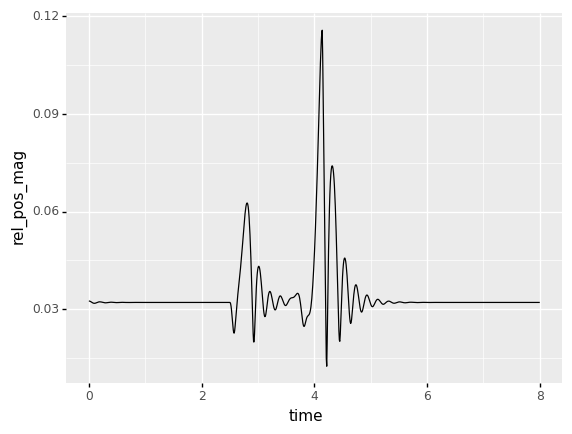

<ggplot: (8743927128073)>


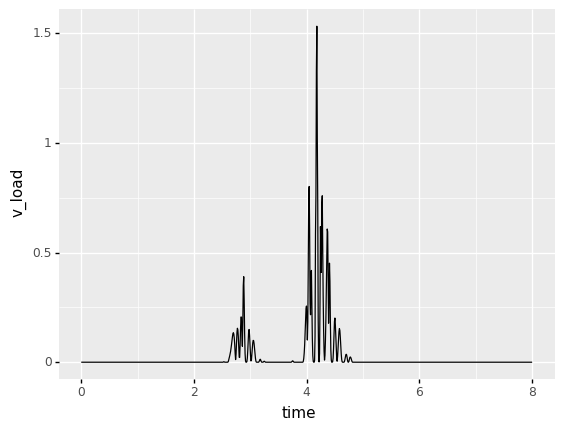

<ggplot: (8743927128313)>


In [15]:
from plotnine import *
print(qplot('time', 'rel_pos_mag', results, geom='line'))
print(qplot('time', 'v_load', results, geom='line'))

In [16]:
def calculate_rms(arr):
    square = arr**2
    sum_square = np.sum(square)
    sqrt_sum_square = np.sqrt(sum_square / len(arr))
    return sqrt_sum_square

unified_model.calculate_metrics(prediction_expr='g(t, x5)', metric_dict={'rms': calculate_rms})

{'rms': 0.12047975983173448}